<a href="https://colab.research.google.com/github/teruyuki-yamasaki/HelloBrax/blob/main/JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [JAX入門～高速なNumPyとして使いこなすためのチュートリアル～](https://qiita.com/koshian2/items/44a871386576b4f80aff)

- [Google - JAX](https://github.com/google/jax): 「自動微分に特化した、GPUやTPUに対応した高速なNumPy」

## 配列
最初はCPUに限定。

In [9]:
import jax.numpy as jnp 

x = jnp.arange(25, dtype=jnp.float32).reshape(5,5) 
print(x) 

[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]
 [20. 21. 22. 23. 24.]]


## .block_until_ready()
- 非同期処理
- 計算の最後に.block_until_ready()
- 特に理由がなければ.block_until_ready()はJAXの計算の最後のみ入れればOK

In [10]:
x_gram = jnp.dot(x, x.T).block_until_ready() 
print(x_gram) 

[[  30.   80.  130.  180.  230.]
 [  80.  255.  430.  605.  780.]
 [ 130.  430.  730. 1030. 1330.]
 [ 180.  605. 1030. 1455. 1880.]
 [ 230.  780. 1330. 1880. 2430.]]


In [11]:
y = x + 1 
x_gram = jnp.dot(x, y.T).block_until_ready()

## Jitting 

このまま使ってもJAX本来の性能を引き出せないので、jitでXLAコンパイル

1. メソッドを@jitとデコレーターで囲む
2. jitでメソッド全体をラップ

.block_until_ready()はjitの外側

### デコレータで@jit

In [12]:
from jax import jit 

@jit 
def static_jax_dot():
    x = jnp.arange(25, dtype=jnp.float32).reshape(5,5) 
    x_gram = jnp.dot(x, x.T) 
    return x_gram 

static_jax_dot().block_until_ready() 

DeviceArray([[  30.,   80.,  130.,  180.,  230.],
             [  80.,  255.,  430.,  605.,  780.],
             [ 130.,  430.,  730., 1030., 1330.],
             [ 180.,  605., 1030., 1455., 1880.],
             [ 230.,  780., 1330., 1880., 2430.]], dtype=float32)

### メソッドをjitでラップ

In [13]:
from jax import jit 

def static_jax_dot_nojit():
    x = jnp.arange(25, dtype=jnp.float32).reshape(5,5) 
    x_gram = jnp.dot(x, x.T) 
    return x_gram 

jit(static_jax_dot_nojit)().block_until_ready() 

DeviceArray([[  30.,   80.,  130.,  180.,  230.],
             [  80.,  255.,  430.,  605.,  780.],
             [ 130.,  430.,  730., 1030., 1330.],
             [ 180.,  605., 1030., 1455., 1880.],
             [ 230.,  780., 1330., 1880., 2430.]], dtype=float32)

### jitでラップした関数に引数を渡す

#### partialでjitをデコレートする

In [20]:
def variable_jax_dot(size):
    x = jnp.arange(size**2, dtype=jnp.float32).reshape(size, size) 
    x_gram = jnp.dot(x, x.T) 
    return x_gram 

jit(variable_jax_dot, static_argnums=(0,))(4).block_until_ready() 

DeviceArray([[ 14.,  38.,  62.,  86.],
             [ 38., 126., 214., 302.],
             [ 62., 214., 366., 518.],
             [ 86., 302., 518., 734.]], dtype=float32)

In [ ]:
from jax import partial 
#ImportError: cannot import name 'partial' from 'jax' 
#(/usr/local/lib/python3.7/dist-packages/jax/__init__.py)

@partial(jit, static_argnums=(0,))
def variable_jax_dot_deco(size):
    x = jnp.arange(size**2, dtype=jnp.float32).reshape(size, size) 
    x_gram = jnp.dot(x, x.T) 
    return x_gram 

variable_jax_dot_deco(5).block_until_ready() 

## パフォーマンス比較

In [35]:
import numpy as np
import jax.numpy as jnp 
from jax import jit #, partial 

def jax_mod(size):
    x = jnp.arange(size, dtype=jnp.int32) 
    mat = x[None, :] * x[:, None] # (size, size) 
    return mat % 256 

def numpy_mod(size):
    x = np.arange(size, dtype=np.int32) 
    mat = x[None, :] * x[:, None] 
    return mat % 256 

L = 50
print('*'*L)
print('\t int32 CPU') 
print('*'*L) 
for i in range(4):
    size = 10**(i+1) 
    repeat = 10**(4-i) 
    print("*** size = ", size, "repeat = ", repeat, ' ***') 

    print('NumPy \t\t', end='')
    %timeit -n {repeat} numpy_mod(size)                                                             # NumPy

    print('JAX w.o. jit \t', end='') 
    %timeit -n {repeat} jax_mod(size).block_until_ready()                                     # JAX w.o. jit

    print('JAX with jit \t', end='') 
    %timeit -n {repeat} jit(jax_mod, static_argnums=(0,))(size).block_until_ready() # JAX with jit 

    print() 

**************************************************
	 int32 CPU
**************************************************
*** size =  10 repeat =  10000  ***
NumPy 		10000 loops, best of 5: 5.5 µs per loop
JAX w.o. jit 	10000 loops, best of 5: 676 µs per loop
JAX with jit 	10000 loops, best of 5: 66.9 µs per loop

*** size =  100 repeat =  1000  ***
NumPy 		1000 loops, best of 5: 68.1 µs per loop
JAX w.o. jit 	1000 loops, best of 5: 783 µs per loop
JAX with jit 	1000 loops, best of 5: 162 µs per loop

*** size =  1000 repeat =  100  ***
NumPy 		100 loops, best of 5: 7.35 ms per loop
JAX w.o. jit 	100 loops, best of 5: 6.34 ms per loop
JAX with jit 	100 loops, best of 5: 1.55 ms per loop

*** size =  10000 repeat =  10  ***
NumPy 		10 loops, best of 5: 520 ms per loop
JAX w.o. jit 	10 loops, best of 5: 355 ms per loop
JAX with jit 	10 loops, best of 5: 40.2 ms per loop



In [44]:
import numpy as np
import jax.numpy as jnp 
from jax import jit #, partial 

def jax_mod(size):
    x = jnp.arange(size, dtype=jnp.float32) 
    mat = x[None, :] * x[:, None] # (size, size) 
    return mat % 256 

def numpy_mod(size):
    x = np.arange(size, dtype=np.float32) 
    mat = x[None, :] * x[:, None] 
    return mat % 256 

L = 50
print('*'*L)
print('\t float32 CPU') 
print('*'*L) 
for i in range(4):
    size = 10**(i+1) 
    repeat = 10**(4-i) 
    print("*** size = ", size, "repeat = ", repeat, ' ***') 

    print('NumPy \t\t', end='')
    %timeit -n {repeat} numpy_mod(size)                                                             # NumPy

    print('JAX w.o. jit \t', end='') 
    %timeit -n {repeat} jax_mod(size).block_until_ready()                                     # JAX w.o. jit

    print('JAX with jit \t', end='') 
    %timeit -n {repeat} jit(jax_mod, static_argnums=(0,))(size).block_until_ready() # JAX with jit 

    print() 

**************************************************
	 float32 CPU
**************************************************
*** size =  10 repeat =  10000  ***
NumPy 		10000 loops, best of 5: 6.79 µs per loop
JAX w.o. jit 	10000 loops, best of 5: 674 µs per loop
JAX with jit 	10000 loops, best of 5: 65.3 µs per loop

*** size =  100 repeat =  1000  ***
NumPy 		1000 loops, best of 5: 257 µs per loop
JAX w.o. jit 	1000 loops, best of 5: 1.08 ms per loop
JAX with jit 	1000 loops, best of 5: 441 µs per loop

*** size =  1000 repeat =  100  ***
NumPy 		100 loops, best of 5: 58.1 ms per loop
JAX w.o. jit 	100 loops, best of 5: 44.9 ms per loop
JAX with jit 	100 loops, best of 5: 42.7 ms per loop

*** size =  10000 repeat =  10  ***
NumPy 		10 loops, best of 5: 7.43 s per loop
JAX w.o. jit 	10 loops, best of 5: 5.54 s per loop
JAX with jit 	10 loops, best of 5: 5.5 s per loop



### デバイスの明示

In [5]:
import jax
from jax import jit
from jax import numpy as jnp

def dot_function():
    x = jnp.arange(1000**2, dtype=jnp.float32).reshape(1000, 1000)
    return jnp.dot(x, x.T)

# devicesは実験的機能で変更される可能性がある
%timeit -n 100 jit(dot_function, device=jax.devices("cpu")[0])().block_until_ready()
# デフォルト。deviceを指定しない場合と一緒
%timeit -n 100 jit(dot_function, device=jax.devices("gpu")[0])().block_until_ready()

100 loops, best of 5: 36.5 ms per loop
The slowest run took 15.07 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 1.28 ms per loop


JAX on Cloud TPU 
- [JAX on Cloud TPU examples](https://github.com/google/jax/tree/main/cloud_tpu_colabs)
-[Lorentz ODE Solver in JAX, Alex Alemi](https://colab.research.google.com/github/google/jax/blob/master/cloud_tpu_colabs/Lorentz_ODE_Solver.ipynb#scrollTo=ReFcuyaKAxh4)


## device_put for NumPy配列との併用

- OpenCVで読み込んだ画像など、NumPy配列とJAXを併用するとき
- device_putでNumPy配列をデバイスに転送しておくと高速に動作

- 一例として、銀河の画像を用います
- Wikipediaにあるハッブル宇宙望遠鏡が撮影した銀河の画像
- 横解像度が6637px、縦解像度が3787pxとかなり巨大な画像
- この巨大な画像を処理する際に高速なJAXが活躍する
- まずファイルをダウンロード（元画像は14.4MB）
- これをOpenCVで読み込み、上から紫色のレイヤーをソフトライトでブレンド

--2022-03-21 10:21:48--  https://upload.wikimedia.org/wikipedia/commons/5/52/Hubble2005-01-barred-spiral-galaxy-NGC1300.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15102249 (14M) [image/jpeg]
Saving to: ‘Hubble2005-01-barred-spiral-galaxy-NGC1300.jpg.24’

Hubble2005-01-barre 100%[===================>]  14.40M  28.6MB/s    in 0.5s    

2022-03-21 10:21:48 (28.6 MB/s) - ‘Hubble2005-01-barred-spiral-galaxy-NGC1300.jpg.24’ saved [15102249/15102249]

(3787, 6637, 3)


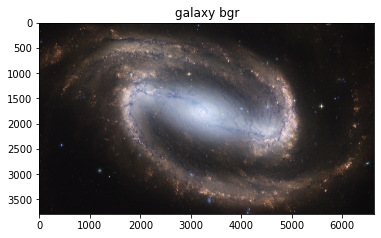

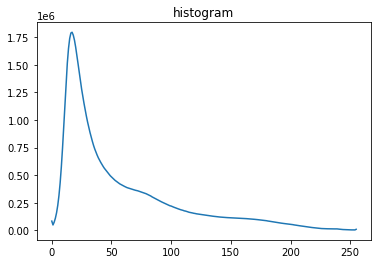

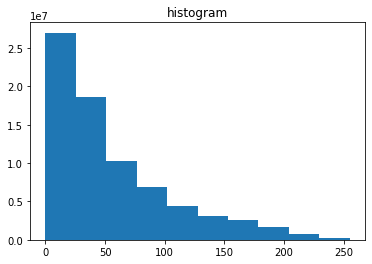

In [48]:
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/Hubble2005-01-barred-spiral-galaxy-NGC1300.jpg
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from google.colab.patches import cv2_imshow

def imshow(image, title):
    if image.max() <= 1: image *= 255 
    image = image.astype(np.uint8) 
    plt.imshow(image) 
    plt.title(title) 
    plt.show()

original_bgr = cv2.imread("Hubble2005-01-barred-spiral-galaxy-NGC1300.jpg")
print(original_bgr.shape)
imshow(original_bgr, 'galaxy bgr')

original_rgb = original_bgr[:,:,::-1]
print(original_rgb.shape)
imshow(original_rgb, 'galaxy rgb')

a,b = np.histogram(original_bgr, bins=256) 
plt.plot(a)
plt.title('histogram')
plt.show()
 
plt.hist(original_bgr.flatten())
plt.title('histogram')
plt.show()

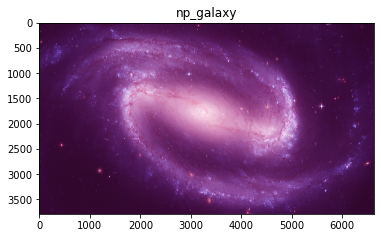

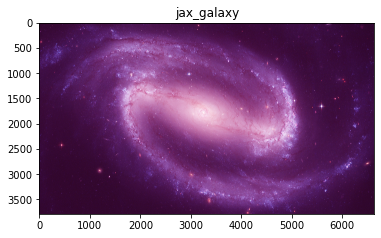

In [55]:
import cv2
import numpy as np 
import jax 
from jax import device_put
from jax import jit 
import jax.numpy as jnp

def np_galaxy():
    original_bgr = cv2.imread("Hubble2005-01-barred-spiral-galaxy-NGC1300.jpg")
    original_rgb = original_bgr[:,:,::-1]
    original = original_rgb.astype(np.float32) / 255.0 
    #imshow(original_bgr, 'bgr'); imshow(original_rgb, 'rgb')

    ones = np.ones(original.shape[:-1], dtype=np.float32)[..., None]
    blend = ones * (np.array([235, 86, 230], dtype=np.float32).reshape(1,1,-1)/255.0) 
    #print(ones.shape, '\n', blend[:2]); print(blend.shape, '\n', blend[:2]) 
    #imshow(blend, 'blend')  

    a = 2*original*blend + original**2*(1-2*blend) 
    b = 2*original*(1-blend) + np.sqrt(original)*(2*blend - 1) 
    out = (blend<0.5)*a + (blend>=0.5)*b 
    #imshow(a, 'a'); imshow(b, 'b') 

    out = (out*255.0).astype(np.uint8) 
    return out 

def jax_galaxy():
    original_bgr = cv2.imread("Hubble2005-01-barred-spiral-galaxy-NGC1300.jpg")
    original_bgr = device_put(original_bgr) 
    original_rgb = original_bgr[:,:,::-1]
    original = original_rgb.astype(jnp.float32) /255.0 

    ones = jnp.ones(original.shape[:-1], dtype=jnp.float32)[..., None] 
    blend = ones * (jnp.array([235, 86, 230], dtype=jnp.float32).reshape(1,1,-1)/255.0) 

    a = 2*original*blend + original**2*(1-2*blend) 
    b = 2*original*(1-blend) + jnp.sqrt(original)*(2*blend - 1) 
    out = (blend<0.5)*a + (blend>=0.5)*b 

    out = (out*255.0).astype(jnp.uint8) 
    return out 

imshow(np_galaxy(), 'np_galaxy')
imshow(jax_galaxy().block_until_ready().astype(np.uint8), 'jax_galaxy')

In [56]:
repeat = 100
%timeit -n {repeat} np_galaxy() 
%timeit -n {repeat} jax_galaxy().block_until_ready()
%timeit -n {repeat} jit(jax_galaxy, device=jax.devices("gpu")[0])().block_until_ready()

100 loops, best of 5: 2.77 s per loop
100 loops, best of 5: 731 ms per loop
The slowest run took 18.45 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 4.74 ms per loop
